In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import xgboost as xgb

import wandb
from wandb.lightgbm import wandb_callback

pd.set_option("display.max_columns", 181)
pd.set_option("display.min_rows", 200)

In [2]:
#!pip install xgboost

In [20]:
data_dictionary = pd.read_csv("DataDictionaryWiDS2021.csv")
unlabeled = pd.read_csv("UnlabeledWiDS2021.csv")
training = pd.read_csv("TrainingWiDS2021.csv")

In [21]:
column_datatype_mapping = dict(zip(data_dictionary['Variable Name'], data_dictionary['Data Type']))

In [22]:
del training['Unnamed: 0']
del unlabeled['Unnamed: 0']

In [6]:
all_data = training.append(unlabeled).drop(['encounter_id', 
                                            'hospital_id', 
                                            'diabetes_mellitus'], axis=1)

all_data.shape

(140391, 177)

In [23]:
cat_cols = ['ethnicity', 'gender', 'hospital_admit_source',
           'icu_admit_source', 'icu_stay_type', 'icu_type',
           'apache_2_diagnosis', 'apache_3j_diagnosis','icu_id']


#all_data = pd.get_dummies(all_data,dummy_na=True,columns=cat_cols)
#all_data = all_data.fillna(-1)

binary_cols = data_dictionary.loc[data_dictionary['Data Type'] == 'binary','Variable Name'].values
num_cols = data_dictionary.loc[data_dictionary['Data Type'] == 'numeric','Variable Name'].values
 

for col in all_data.columns:
    if col in cat_cols:
        print(col)
        all_data[col] = LabelEncoder().fit_transform(all_data[col].astype('str'))
        #all_data[col]= all_data[col].astype('str')        

ethnicity
gender
hospital_admit_source
icu_admit_source
icu_id
icu_stay_type
icu_type
apache_2_diagnosis
apache_3j_diagnosis


In [24]:
'''from sklearn.decomposition import PCA

all_data = all_data.fillna(-1)

pca = PCA(n_components = 'mle',svd_solver = 'full')
pca.fit(all_data)
all_data_pca = pd.DataFrame(pca.transform(all_data))'''

"from sklearn.decomposition import PCA\n\nall_data = all_data.fillna(-1)\n\npca = PCA(n_components = 'mle',svd_solver = 'full')\npca.fit(all_data)"

In [13]:
all_data_pca.shape, all_data.shape

((140391, 173), (140391, 177))

In [25]:
df_train = all_data[:len(training)]
df_pred = all_data[len(training):].reset_index(drop=True)
Y = training['diabetes_mellitus']

In [26]:
df_train.columns

Index(['age', 'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height',
       'hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type',
       ...
       'h1_arterial_po2_min', 'h1_pao2fio2ratio_max', 'h1_pao2fio2ratio_min',
       'aids', 'cirrhosis', 'hepatic_failure', 'immunosuppression', 'leukemia',
       'lymphoma', 'solid_tumor_with_metastasis'],
      dtype='object', length=177)

In [27]:
X_train, X_val, y_train, y_val = train_test_split(df_train, Y, test_size=0.20, random_state=42,shuffle=True )

In [28]:
xg_train = xgb.DMatrix(X_train.values, label=y_train)
xg_test = xgb.DMatrix(X_val.values, label=y_val)

In [29]:
wandb.init(project="wids_2021", sync_tensorboard=True)
config = wandb.config


param = {'subsample': 1.0, 
         'num_leaves': 10, 
         'min_child_weight': 1, 
         'max_depth': 6, 
         'learning_rate': 0.1, 
         'gamma': 1.5, 
         'colsample_bytree': .6,
         'n_estimators':1000,
          'eval_metric':'auc',
          'objective': 'binary:logistic'}

# wandb.config.update(params)

watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 1000
bst = xgb.train(param, xg_train, num_round, watchlist, callbacks=[wandb.xgboost.wandb_callback()])

# get prediction
pred = bst.predict(xg_test)

train-auc,0.9201
test-auc,0.83571
_step,175
_runtime,230
_timestamp,1613240872


train-auc,▁▂▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████
test-auc,▁▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[18:28:38] WARNING: ../src/learner.cc:541: 
Parameters: { n_estimators, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.79844	test-auc:0.78589
[1]	train-auc:0.80588	test-auc:0.79290
[2]	train-auc:0.82175	test-auc:0.80798
[3]	train-auc:0.82916	test-auc:0.81547
[4]	train-auc:0.83189	test-auc:0.81945
[5]	train-auc:0.83315	test-auc:0.82014
[6]	train-auc:0.83421	test-auc:0.82090
[7]	train-auc:0.83649	test-auc:0.82332
[8]	train-auc:0.83827	test-auc:0.82528
[9]	train-auc:0.83896	test-auc:0.82587
[10]	train-auc:0.83984	test-auc:0.82653
[11]	train-auc:0.84054	test-auc:0.82697
[12]	train-auc:0.84111	test-auc:0.82717
[13]	train-auc:0.84337	test-auc:0.82886
[14]	train-auc:0.84489	test-auc:0.83005
[15]	train-auc:0.84559	test-auc:0.83059
[16]	train-auc:0.84643	tes

In [75]:
pd.DataFrame(pred).to_csv('submissions/xgb_pred.csv')

In [30]:
#bst.fit(df_train.values, Y.values)
#0.9692300714861747
metrics.roc_auc_score(Y.values, bst.predict(xgb.DMatrix(df_train.values)))

0.968302463188419

In [29]:
pred_proba = bst.predict(xgb.DMatrix(df_pred.values))

#pred_proba = xgbm.predict_proba(df_pred.values)[:,1]]

In [31]:
submittion = pd.DataFrame([unlabeled.encounter_id,pred_proba]).T
submittion.encounter_id = submittion.encounter_id.astype('int32')
submittion.set_index('encounter_id',inplace=True)
submittion.columns = ['diabetes_mellitus']
submittion.to_csv('submissions/SolutionWiDS2021_XGB_1000_epochs_onehot_pca.csv')

## XGB fit on the entire dataset

In [39]:
xg_train = xgb.DMatrix(df_train.values, label=Y)
xg_test = xgb.DMatrix(X_val.values, label=y_val)

In [40]:
wandb.init(project="wids_2021", sync_tensorboard=True)
config = wandb.config


param = {'subsample': 1.0, 
         'num_leaves': 10, 
         'min_child_weight': 1, 
         'max_depth': 6, 
         'learning_rate': 0.1, 
         'gamma': 1.5, 
         'colsample_bytree': .6,
         'n_estimators':1000,
          'eval_metric':'auc',
          'objective': 'binary:logistic',
          'early_stopping_rounds':50}

# wandb.config.update(params)

watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 1000
bst = xgb.train(param, xg_train, num_round, watchlist, callbacks=[wandb.xgboost.wandb_callback()])

# get prediction
pred = bst.predict(xg_test)

train-auc,0.96323
test-auc,0.96416
_step,999
_runtime,1546
_timestamp,1612995669


train-auc,▁▂▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████
test-auc,▁▂▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[22:32:41] WARNING: ../src/learner.cc:541: 
Parameters: { early_stopping_rounds, n_estimators, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.81724	test-auc:0.81474
[1]	train-auc:0.82481	test-auc:0.82294
[2]	train-auc:0.82825	test-auc:0.82599
[3]	train-auc:0.83127	test-auc:0.82937
[4]	train-auc:0.83399	test-auc:0.83197
[5]	train-auc:0.83592	test-auc:0.83387
[6]	train-auc:0.83762	test-auc:0.83547
[7]	train-auc:0.83864	test-auc:0.83657
[8]	train-auc:0.83928	test-auc:0.83716
[9]	train-auc:0.84061	test-auc:0.83857
[10]	train-auc:0.84167	test-auc:0.83982
[11]	train-auc:0.84283	test-auc:0.84096
[12]	train-auc:0.84425	test-auc:0.84227
[13]	train-auc:0.84528	test-auc:0.84346
[14]	train-auc:0.84659	test-auc:0.84468
[15]	train-auc:0.84751	test-auc:0.84564
[16

In [42]:
pred_proba = bst.predict(xgb.DMatrix(df_pred.values))

submittion = pd.DataFrame([unlabeled.encounter_id,pred_proba]).T
submittion.encounter_id = submittion.encounter_id.astype('int32')
submittion.set_index('encounter_id',inplace=True)
submittion.columns = ['diabetes_mellitus']
submittion.to_csv('SolutionWiDS2021_XGB_1000_epochs_onehot_entire_dataset.csv')

### CV with random hpopt

In [10]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5],
        'gamma': [0.5, 1.5, 3],
        'subsample': [0.6, 1.0],
        'colsample_bytree': [0.6, 1.0],
        'max_depth': [4, 5, 6],
        'num_leaves': [10, 20, 30],
        'learning_rate': [0.01, 0.1, 0.2, 0.4]
        }


In [11]:
xgb = XGBClassifier(n_estimators=200, objective='binary:logistic', verbose=1)

In [18]:
folds = 4
param_comb = 250

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', 
                                   n_jobs=32, cv=skf.split(df_train.values, Y), verbose=3, 
                                   random_state=1001)


In [ ]:
# Here we go
import time
start=time.time()
random_search.fit(df_train.values, Y)
print(time.time()-start)

Fitting 4 folds for each of 250 candidates, totalling 1000 fits


In [20]:
random_search

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f7cb6aeb5d0>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing...
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                           validate_parameters=None, verbose=1,
                                          

In [22]:
print(random_search.best_params_)

{'subsample': 1.0, 'num_leaves': 10, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 1.5, 'colsample_bytree': 0.6}


In [23]:
pred_proba_rs = random_search.predict_proba(df_pred.values)

In [ ]:
# (pred_proba, pred_proba_rs[:,1])

(array([4852., 1681.,  888.,  690.,  572.,  461.,  417.,  394.,  224.,
          55.]),
 array([7.5848104e-04, 9.6810319e-02, 1.9286215e-01, 2.8891400e-01,
        3.8496581e-01, 4.8101765e-01, 5.7706946e-01, 6.7312133e-01,
        7.6917315e-01, 8.6522502e-01, 9.6127683e-01], dtype=float32),
 <BarContainer object of 10 artists>)

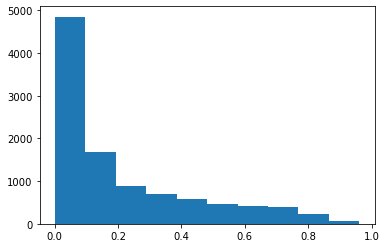

In [24]:
import matplotlib.pyplot as plt
plt.hist(pred_proba_rs[:,1])

In [84]:
submittion = pd.DataFrame([unlabeled.encounter_id,pred_proba_rs[:,1]]).T
submittion.encounter_id = submittion.encounter_id.astype('int32')
submittion.set_index('encounter_id',inplace=True)
submittion.columns = ['diabetes_mellitus']
submittion.fillna(0.5).to_csv('SolutionWiDS2021_XGB_200_epochs_CV_RandomSearch_200runs.csv')